In [1]:
#%pip install yfinance
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime 
import yfinance as yf
from scipy.interpolate import interp1d 
from scipy.stats import linregress 
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df_allstocks = pd.read_csv("C:/Users/ikry/Downloads/stock_details_5_years.csv")
df_allstocks

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA
...,...,...,...,...,...,...,...,...,...
602957,2023-11-29 00:00:00-05:00,26.360001,26.397499,26.120001,26.150000,1729147,0.00,0.0,PPL
602958,2023-11-29 00:00:00-05:00,27.680000,28.535000,27.680000,28.350000,1940066,0.00,0.0,FITB
602959,2023-11-29 00:00:00-05:00,75.940002,76.555000,75.257500,75.610001,298699,0.00,0.0,IFF
602960,2023-11-29 00:00:00-05:00,45.230000,45.259998,44.040001,44.209999,2217579,0.00,0.0,CCJ


In [3]:
df_allstocks = df_allstocks.pivot(index='Date', columns='Company', values='Close')
df_allstocks.reset_index(inplace=True)
df_allstocks.columns.name = None
df_allstocks = df_allstocks.set_index('Date')

In [4]:
def select_stocks(tickers):
    df_portfolio = df_allstocks[tickers]
    df_portfolio = df_portfolio.loc[start_date:end_date]
    return df_portfolio

def stock_price_dist(df_portfolio):
    df_returns = df_portfolio.pct_change().dropna()
    df_returns.hist(bins=100, figsize=(12, 6), color='skyblue', alpha=0.7)
    plt.tight_layout()
    plt.show()
    return df_returns

def close_price_history(df_portfolio):
    fig, ax = plt.subplots(figsize=(15,8))
    for i in df_portfolio.columns.values :
        ax.plot(df_portfolio[i], label = i)
    ax.set_title("Portfolio Close Price History")
    ax.set_xlabel('Date', fontsize=18)
    ax.set_ylabel('Close Price ($)' , fontsize=18)
    ax.legend(df_portfolio.columns.values , loc = 'upper right')
    # plt.xticks(rotation=90)
    plt.show(fig)

def cumulative_returns(df_returns):

    daily_cummulative_simple_return =(df_returns+1).cumprod()
    fig, ax = plt.subplots(figsize=(18,8))
    for i in daily_cummulative_simple_return.columns.values :
        ax.plot(daily_cummulative_simple_return[i], lw =2 ,label = i)

    ax.legend( loc = 'upper left' , fontsize =10)
    ax.set_title('Daily Cumulative Simple returns/growth of investment')
    ax.set_xlabel('Date')
    ax.set_ylabel('Growth of ₨ 1 investment')
    plt.show()

def correlation_matrix(df_returns):
    # Plot the correlation matrix heatmap
    sns.heatmap(df_returns.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Correlation'})
    plt.title('Correlation Matrix')



In [5]:
# building optimized portfolio

def build_opt_portfolio(df_returns):

    # Calculate mean returns and covariance matrix
    mean_returns = df_returns.mean()
    cov_matrix = df_returns.cov()

    # Number of portfolios to simulate
    num_portfolios = 10000

    # Results storage
    results = np.zeros((3, num_portfolios))
    port_wts = []

    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        port_wts.append(weights)

        # Expected portfolio return
        portfolio_return = np.sum(weights * mean_returns) * 252  

        # Expected portfolio volatility
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

        # Portfolio Sharpe ratio (assuming risk-free rate is zero)
        sharpe_ratio = portfolio_return / portfolio_stddev

        results[0,i] = portfolio_return
        results[1,i] = portfolio_stddev
        results[2,i] = sharpe_ratio


    # Convert results array to Pandas DataFrame
    results_df = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe Ratio'])
    results_df['port_wts'] = [np.round(wt,2) for wt in port_wts]    
    print(results_df)


    # Find the portfolio with the maximum Sharpe ratio
    max_sharpe_portfolio = results_df.iloc[results_df['Sharpe Ratio'].idxmax()]
    print(max_sharpe_portfolio)


    # Find the portfolio with the minimum volatility
    min_volatility_portfolio = results_df.iloc[results_df['Volatility'].idxmin()]

    # Plot the efficient frontier
    plt.figure(figsize=(8, 6))
    plt.scatter(results_df.Volatility, results_df.Return, c=results_df['Sharpe Ratio'], cmap='plasma', marker='o', s=10, alpha=0.3)
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'], marker='*', color='r', s=200, label='Max Sharpe Ratio')
    plt.scatter(min_volatility_portfolio['Volatility'], min_volatility_portfolio['Return'], marker='*', color='b', s=200, label='Min Volatility')
    plt.title('Efficient Frontier')
    plt.xlabel('Volatility (Annualized)')
    plt.ylabel('Return (Annualized)')
    plt.legend()
    plt.show()

In [6]:
def generate_portfolio(tickers):
    df_portfolio = select_stocks(tickers)
    print('Calculating the returns fromt the stock:')
    df_returns = stock_price_dist(df_portfolio)
    print('Calculating historical price trends:')
    close_price_history(df_portfolio)
    print('Calculating cumulative price trends:')
    cumulative_returns(df_returns)
    print('Calculating correlation between stocks in the portfolio:')
    correlation_matrix(df_returns)
    print('Building the optimized portfolio from selected stocks:')
    build_opt_portfolio(df_returns)

Calculating the returns fromt the stock:


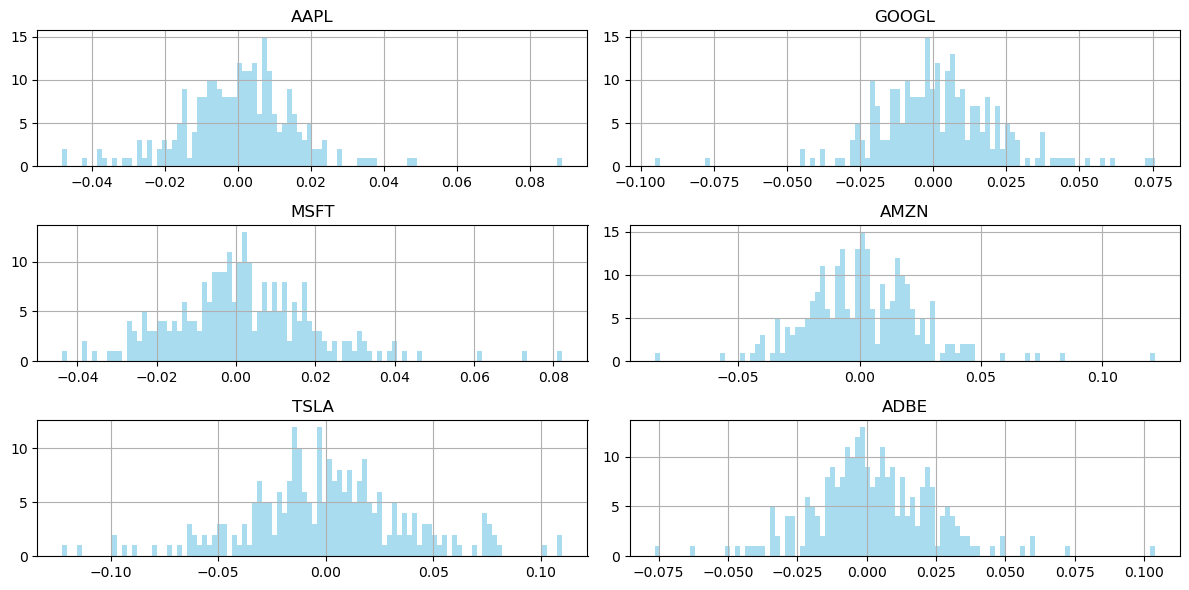

Calculating historical price trends:


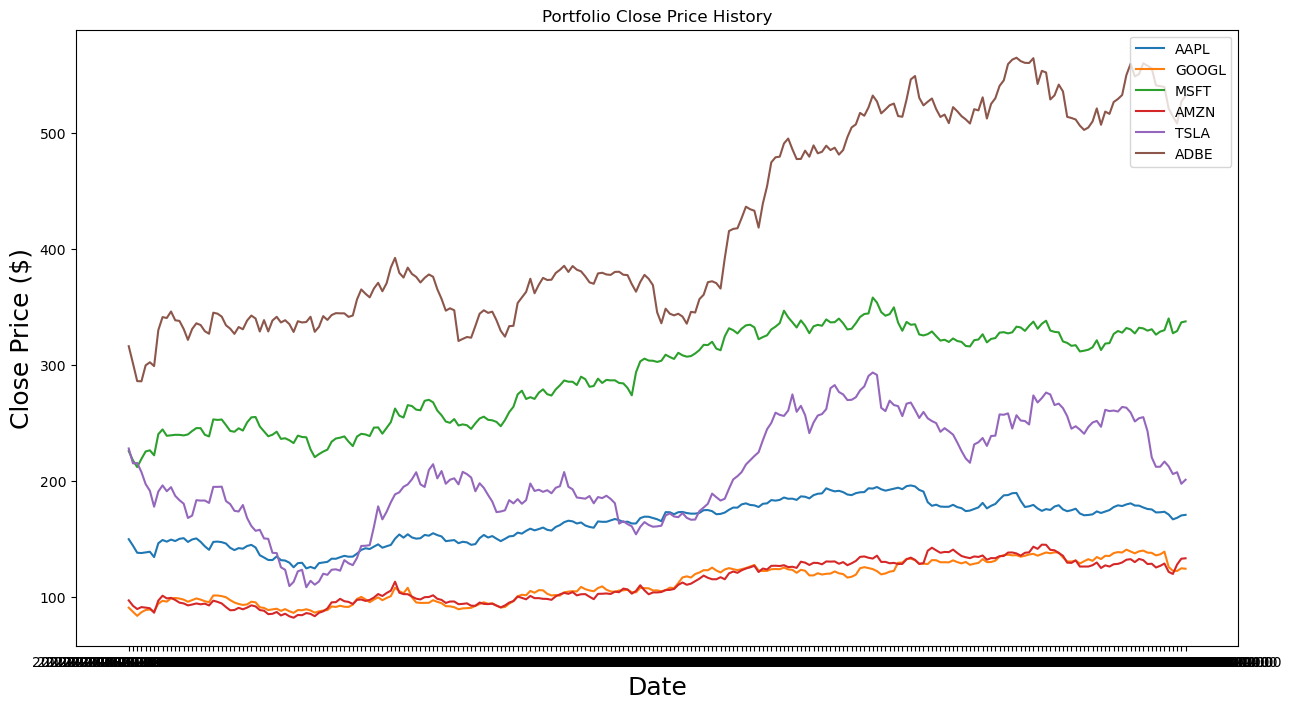

Calculating cumulative price trends:


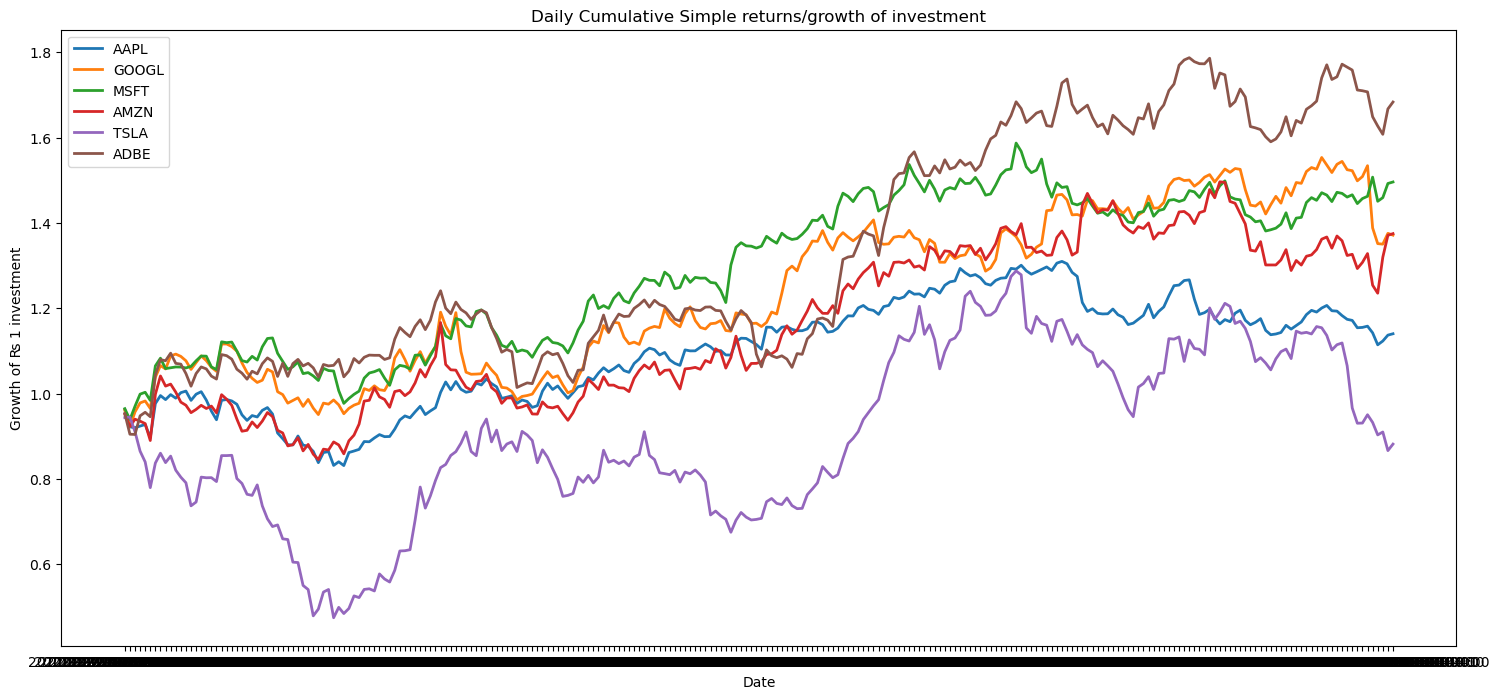

Calculating correlation between stocks in the portfolio:
Building the optimized portfolio from selected stocks:
        Return  Volatility  Sharpe Ratio                              port_wts
0     0.327865    0.289003      1.134467    [0.15, 0.12, 0.2, 0.18, 0.2, 0.15]
1     0.350963    0.291977      1.202025    [0.11, 0.1, 0.2, 0.17, 0.19, 0.22]
2     0.322640    0.290899      1.109113   [0.13, 0.22, 0.19, 0.1, 0.22, 0.14]
3     0.357943    0.285482      1.253818  [0.09, 0.28, 0.16, 0.18, 0.14, 0.16]
4     0.260518    0.309914      0.840614  [0.22, 0.19, 0.04, 0.19, 0.28, 0.08]
...        ...         ...           ...                                   ...
9995  0.364661    0.287679      1.267597   [0.02, 0.31, 0.26, 0.16, 0.15, 0.1]
9996  0.310268    0.298314      1.040069  [0.06, 0.37, 0.21, 0.13, 0.22, 0.01]
9997  0.361583    0.273433      1.322380  [0.14, 0.11, 0.34, 0.08, 0.15, 0.18]
9998  0.332471    0.291476      1.140648   [0.09, 0.29, 0.18, 0.31, 0.13, 0.0]
9999  0.310795    0

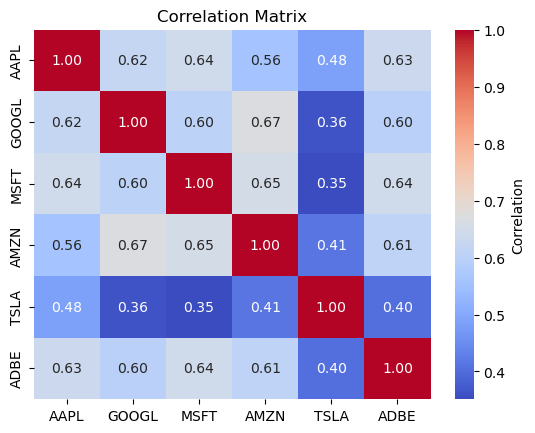

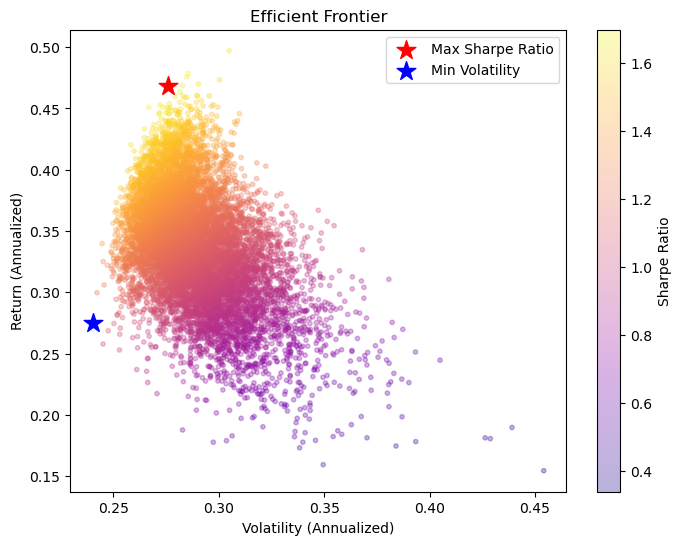

In [7]:
# optimized portfolio of Tech stocks
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'ADBE']
start_date = "2022-11-01"
end_date = "2023-11-01"

generate_portfolio(tickers)

Calculating the returns fromt the stock:


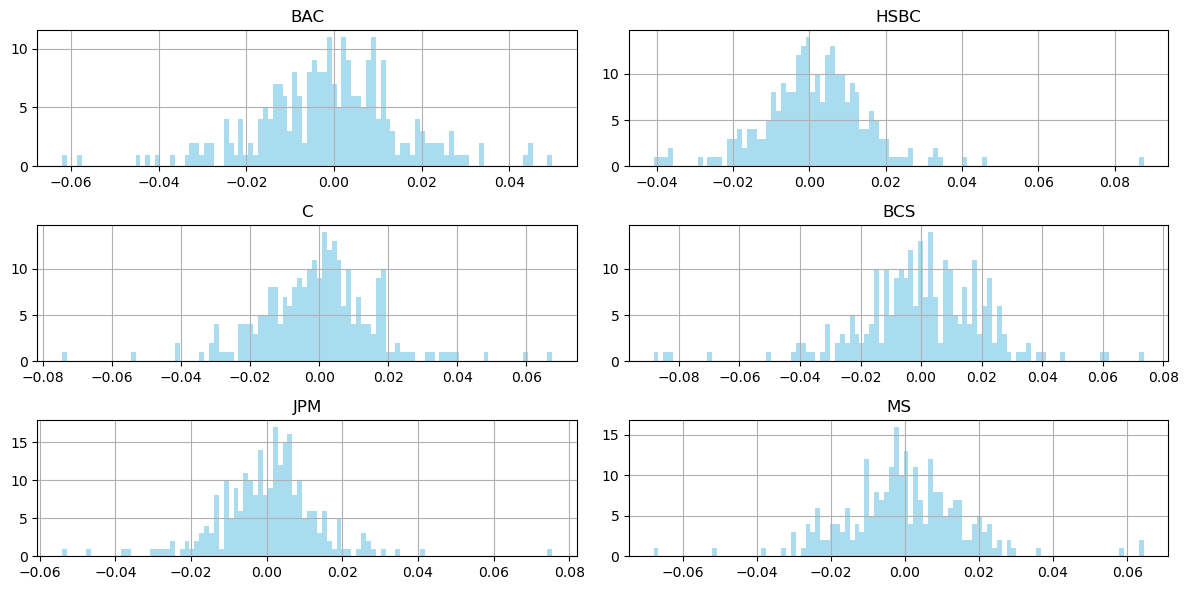

Calculating historical price trends:


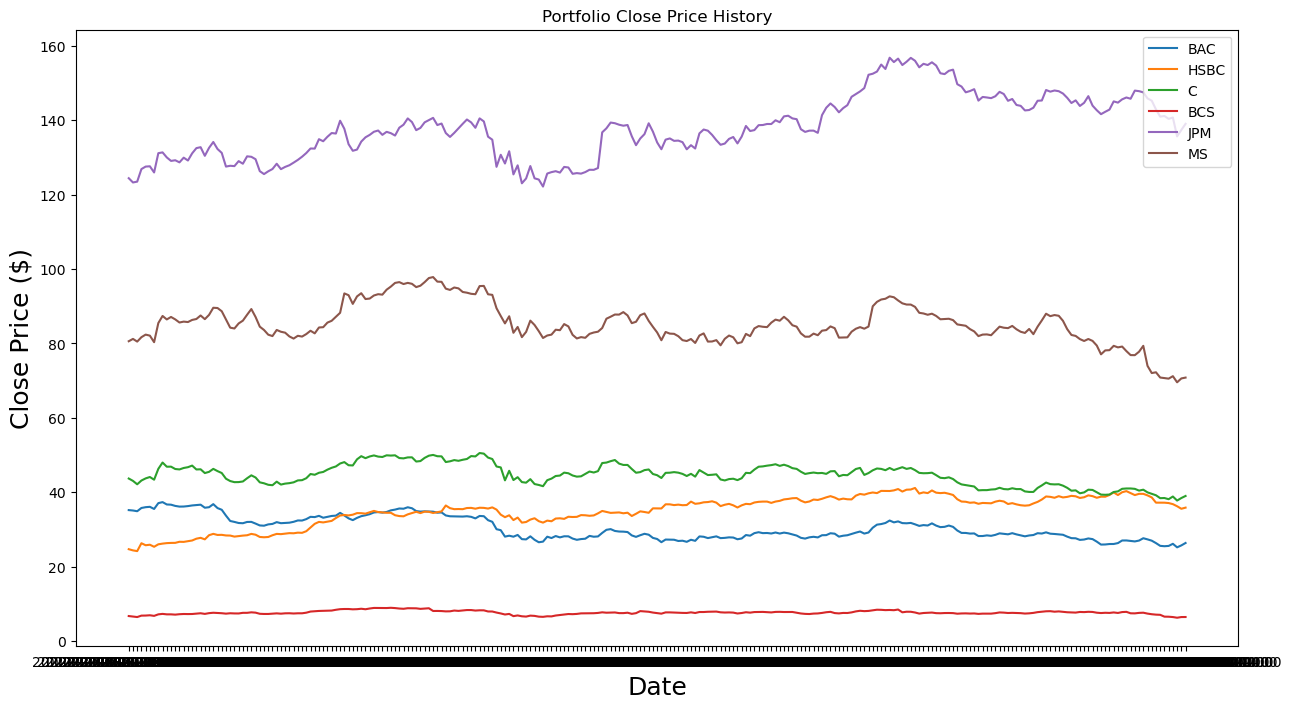

Calculating cumulative price trends:


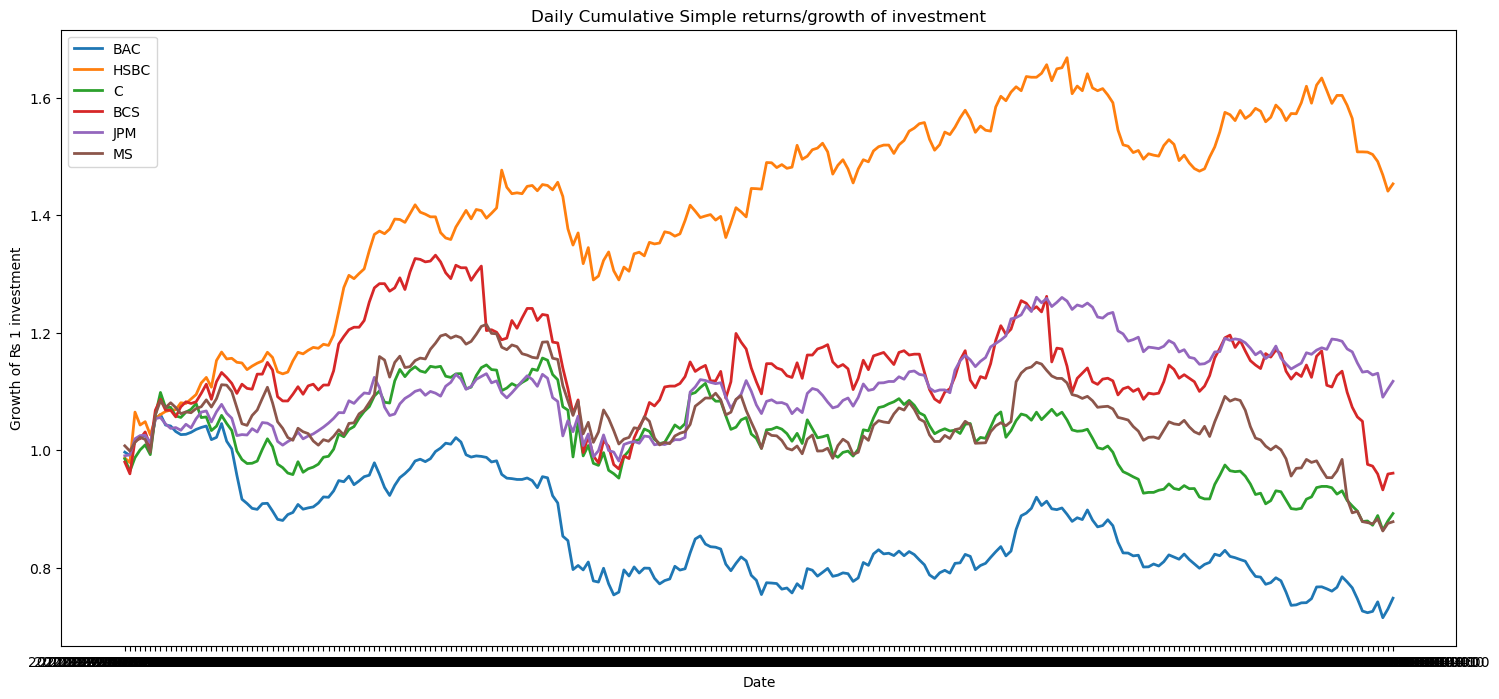

Calculating correlation between stocks in the portfolio:
Building the optimized portfolio from selected stocks:
        Return  Volatility  Sharpe Ratio                              port_wts
0     0.043599    0.211734      0.205916   [0.04, 0.16, 0.25, 0.15, 0.2, 0.21]
1     0.098565    0.212783      0.463217  [0.06, 0.19, 0.06, 0.26, 0.34, 0.09]
2     0.075516    0.227595      0.331799   [0.14, 0.31, 0.01, 0.33, 0.01, 0.2]
3     0.076498    0.208532      0.366842  [0.14, 0.23, 0.13, 0.18, 0.24, 0.08]
4     0.025147    0.220941      0.113820   [0.16, 0.2, 0.04, 0.25, 0.07, 0.27]
...        ...         ...           ...                                   ...
9995 -0.011762    0.216873     -0.054235   [0.26, 0.2, 0.32, 0.09, 0.06, 0.07]
9996  0.057148    0.226258      0.252580  [0.13, 0.25, 0.26, 0.29, 0.05, 0.02]
9997  0.005581    0.223731      0.024945  [0.06, 0.08, 0.19, 0.25, 0.17, 0.25]
9998 -0.030399    0.210497     -0.144417    [0.27, 0.1, 0.1, 0.04, 0.23, 0.26]
9999 -0.024201    0

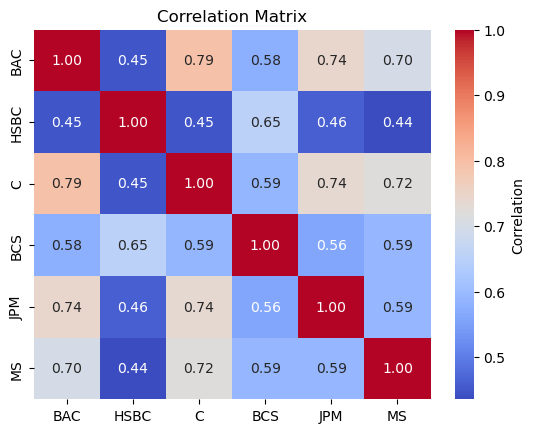

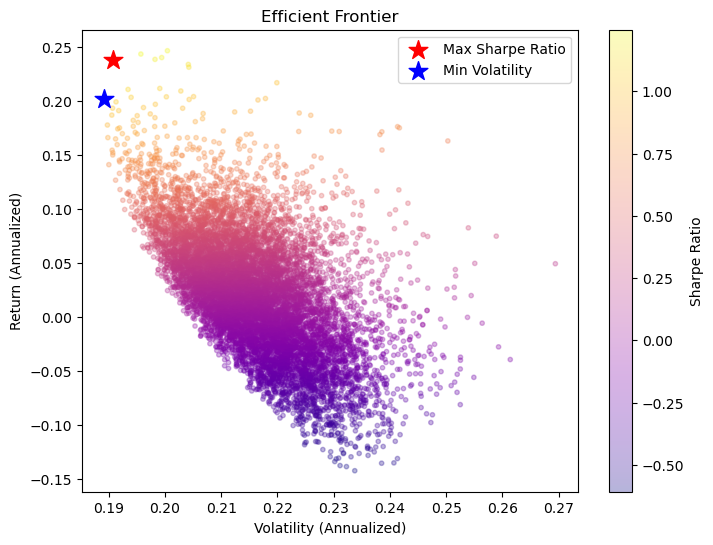

In [8]:
#optimized portfolio of Banking & Financial stocks

tickers = ['BAC', 'HSBC', 'C', 'BCS', 'JPM', 'MS']
start_date = "2022-11-01"
end_date = "2023-11-01"

generate_portfolio(tickers)